# Data Wrangling for Graph Neural Networks in PyTorch Geometric



In [1]:
#| default_exp data

In [1]:
#| hide
from nbdev.showdoc import *

In [2]:
#| export

import pandas as pd
from pathlib import Path
from typing import List
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import from_networkx 

from torch_geometric.data import Data as PyGData


In [3]:
def fix_column_names(df: pd.DataFrame) -> pd.DataFrame:
    # remove leading and trailing whitespace from column names
    df.columns = df.columns.str.strip()
    # replace spaces with underscores
    df.columns = df.columns.str.replace(' ', '_')
    # replace parentheses with underscores
    df.columns = df.columns.str.replace('(', '_')
    df.columns = df.columns.str.replace(')', '_')
    # replace slashes with underscores
    df.columns = df.columns.str.replace('/', '_')
    # replace dashes with underscores
    df.columns = df.columns.str.replace('-', '_')
    # replace dots with underscores
    df.columns = df.columns.str.replace('.', '_')
    # replace colons with underscores
    df.columns = df.columns.str.replace(':', '_')
    
    return df



def get_all_datafiles() -> List[Path]:
    # recursively find all .csv files in the data directory
    data_dir = Path('../data/raw/')
    all_files = list(data_dir.glob('**/*.csv'))
    print("Found {} files".format(len(all_files)))
    # get the name of the malware family from the directory name
    all_classifications = [f.parent.name for f in all_files]
    
    def process_file(f: Path) -> pd.DataFrame:
        variant = f.parent.name
        family = f.parent.parent.name
        df = pd.read_csv(f)
        df['variant'] = variant
        df['family'] = family
        return df
    
    # stack the data and labels into a single dataframe
    all_data = pd.concat([process_file(f) for f in all_files], axis=0)
    all_data = fix_column_names(all_data)
    all_data = all_data.convert_dtypes()
    for column in all_data.columns:
        if all_data[column].dtype == 'object':
            # convert to a float or Nan if not possible
            all_data[column] = pd.to_numeric(all_data[column], errors='coerce')
    print("Combined data shape: {}".format(all_data.shape))
    # print each column and its data type
    zip_obj = zip(all_data.columns, all_data.dtypes)
    for column, dtype in zip_obj:
        print("Column: {}, dtype: {}".format(column, dtype))
        
    # convert the dataframe variant and family columns to categorical
    all_data['variant'] = all_data['variant'].astype('category')
    all_data['family'] = all_data['family'].astype('category')
    
    all_data.to_parquet('../data/combined.parquet', index=False)
    return all_classifications
    

In [4]:
df = get_all_datafiles()

Found 2126 files


/home/khannay/miniconda3/envs/gnnflows/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1056: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
/home/khannay/miniconda3/envs/gnnflows/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1080: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


Combined data shape: (2616579, 87)
Column: Flow_ID, dtype: string
Column: Source_IP, dtype: string
Column: Source_Port, dtype: Int64
Column: Destination_IP, dtype: string
Column: Destination_Port, dtype: Float64
Column: Protocol, dtype: Float64
Column: Timestamp, dtype: string
Column: Flow_Duration, dtype: Int64
Column: Total_Fwd_Packets, dtype: Int64
Column: Total_Backward_Packets, dtype: Float64
Column: Total_Length_of_Fwd_Packets, dtype: Float64
Column: Total_Length_of_Bwd_Packets, dtype: Float64
Column: Fwd_Packet_Length_Max, dtype: Int64
Column: Fwd_Packet_Length_Min, dtype: Float64
Column: Fwd_Packet_Length_Mean, dtype: Float64
Column: Fwd_Packet_Length_Std, dtype: Float64
Column: Bwd_Packet_Length_Max, dtype: Float64
Column: Bwd_Packet_Length_Min, dtype: Float64
Column: Bwd_Packet_Length_Mean, dtype: Float64
Column: Bwd_Packet_Length_Std, dtype: Float64
Column: Flow_Bytes_s, dtype: Float64
Column: Flow_Packets_s, dtype: Float64
Column: Flow_IAT_Mean, dtype: Float64
Column: Flow_

In [15]:
all_data = pd.read_parquet('../data/combined.parquet')

In [17]:
all_data['variant'].dtype

CategoricalDtype(categories=['AVforAndroid', 'AVpass', 'AndroidDefender', 'AndroidSpy',
                  'Beanbot', 'Benign2015', 'Benign2016', 'Benign2017', 'Biige',
                  'Charger', 'Dowgin', 'Ewind', 'FakeAV', 'FakeApp',
                  'FakeAppAL', 'FakeJobOffer', 'FakeMart', 'FakeNotify',
                  'FakeTaoBao', 'Fakeinst', 'Feiwo', 'Gooligan', 'Jifake',
                  'Jisut', 'Kemoge', 'Koler', 'Koodous', 'Lockerpin',
                  'Mazarbot', 'Mobidash', 'Nandrobox', 'Penetho', 'Plankton',
                  'Pletor', 'PornDroid', 'RansomBO', 'SMSsniffer', 'SVpeng',
                  'Selfmite', 'Shuanet', 'Simplocker', 'VirusShield',
                  'WannaLocker', 'Youmi', 'Zsone'],
, ordered=False, categories_dtype=object)

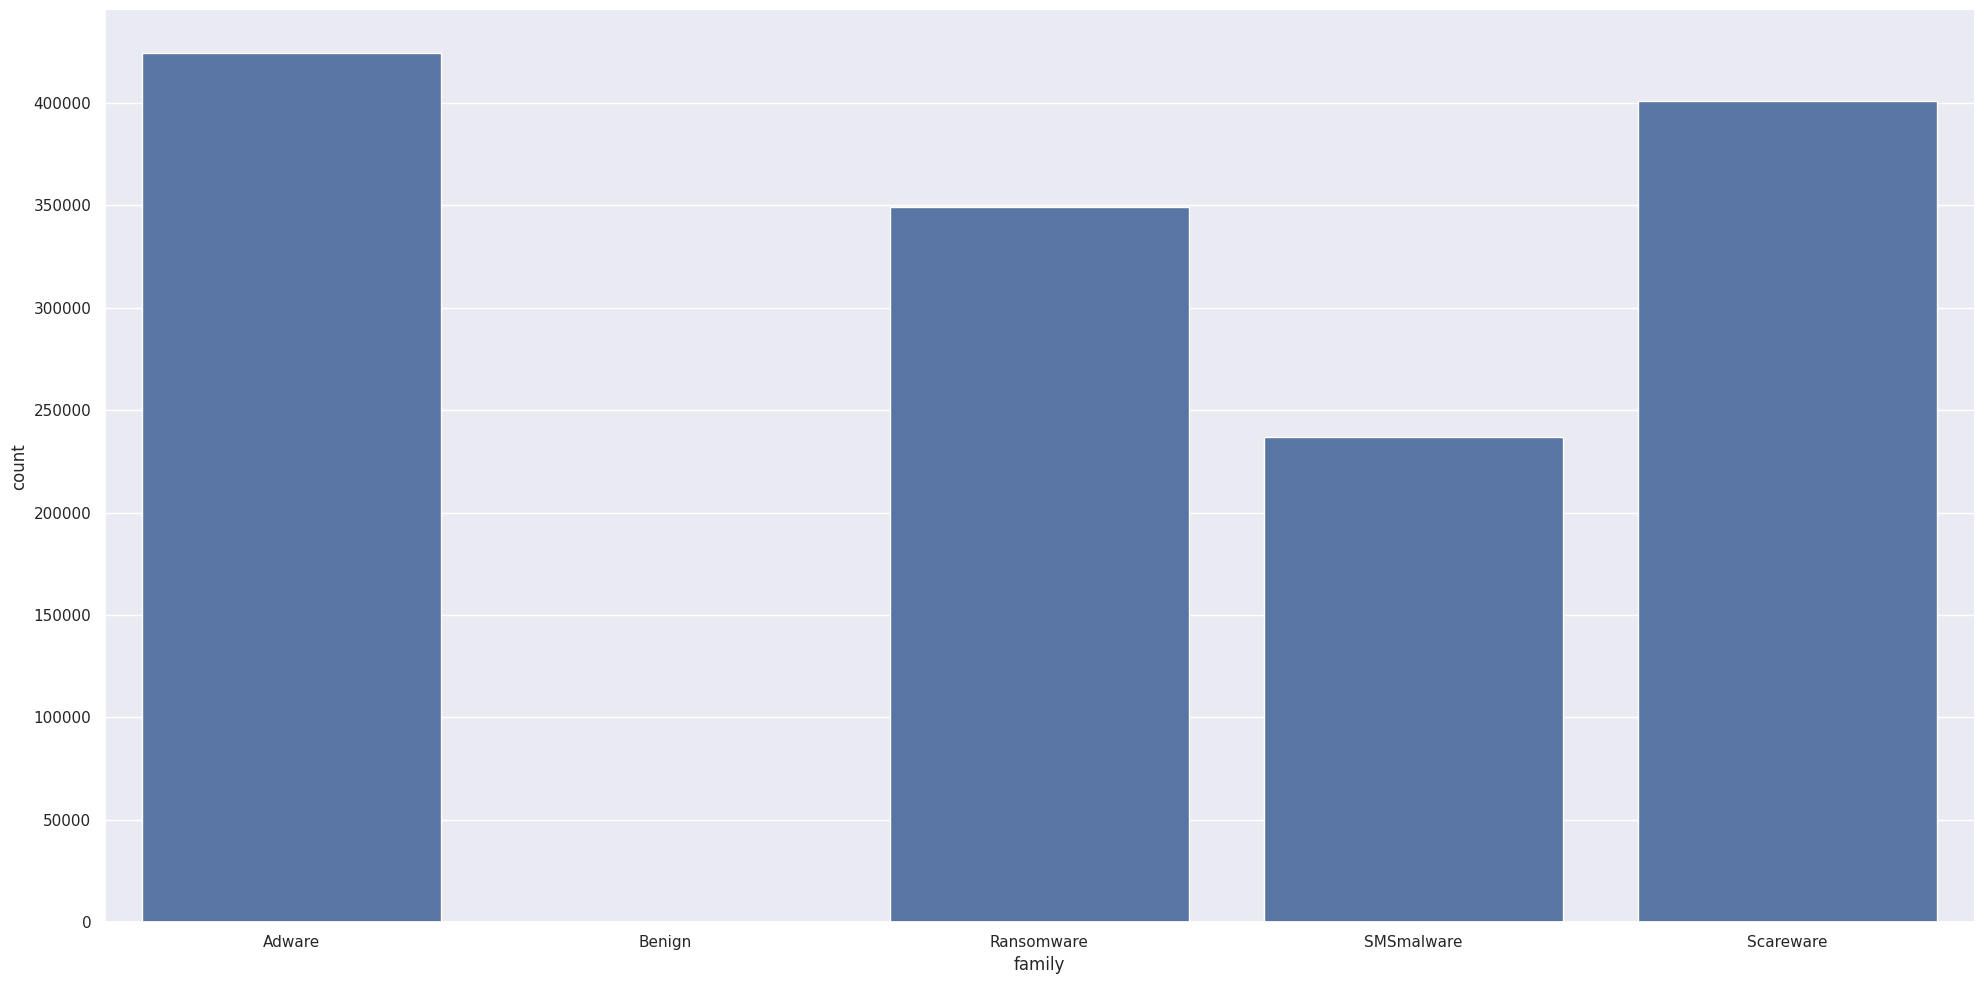

In [32]:
import seaborn as sns

# find the counts for each malware family
family_counts = all_data['family'].value_counts().sort_values(ascending=True)
variant_counts = all_data['variant'].value_counts().sort_values(ascending=True)

# make a bar plot of the counts using seaborn

# fig, ax = plt.subplots(figsize=(10, 10))
sns.catplot(data=all_data[all_data["family"] != "Benign"], x="family", kind="count", height=10, aspect=2)
# ax.set_title('Malware Family Counts')
# ax.set_xlabel('Count')
# ax.set_ylabel('Family')
plt.show()

In [50]:
import os.path as osp
from typing import List, Tuple, Dict
import torch
from torch_geometric.data import Dataset, download_url
from pdb import set_trace
import os
from torch_geometric.utils.convert import to_networkx
from collections import Counter
import random 
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from functools import cached_property

class MalwareDataset(Dataset):
    def __init__(
        self,
        root="../data/",
        transform=None,
        pre_transform=None,
        pre_filter=None,
        limit=None,
        skip_processing=False,
        random_seed=42,
    ):
        self.skip_processing = skip_processing
        self.limit = limit
        super().__init__(root, transform, pre_transform, pre_filter)
        self.random_seed = random_seed
        random.seed(self.random_seed)

    @property
    def raw_file_names(self) -> List[Path]:
        data_dir = Path(self.root)
        all_files = list(data_dir.glob("**/*.csv"))
        rel_files = [
            os.path.relpath(f, os.path.join(self.root, "raw")) for f in all_files
        ]
        random.shuffle(rel_files)
        return rel_files if self.limit is None else rel_files[: self.limit]

    @property
    def processed_file_names(self):
        raw_files = [f.split(".")[0] for f in self.raw_file_names]
        return [f + ".pt" for f in raw_files]

    def download(self):
        pass
    
    @property
    def fraction_benign(self) -> float:
        count_benign = 0
        for idx in range(len(self)):
            data = self.get(idx)
            if data.y[0] == 0:
                count_benign += 1
                
        return count_benign / len(self)
    
    @cached_property
    def variants(self) -> List[str]:
        return [Path(f).parent.parent.name for f in self.raw_paths]
    
    @cached_property
    def malware_families(self) -> List[str]:
        return [Path(f).parent.name for f in self.raw_paths]
    
    @property
    def malware_variants(self) -> Counter:
        """
            Get the count of each malware variant in the dataset
        """
        return Counter(self.variants)
    

    def process(self):
        if self.skip_processing:
            return
        idx = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            data = self.process_data_helper(raw_path)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, f"data_{idx}.pt"))
            idx += 1

    def to_networkx(self, idx: int = 0) -> nx.DiGraph:
        data = self.get(idx)
        return to_networkx(data)


    def plot_graph(self, idx: int = 0, layout = nx.spring_layout, ax: plt.Axes = None, *args, **kwargs) -> None:
        if ax is None:
            fig, ax = plt.subplots()
        G = self.to_networkx(idx)
        nx.draw(G, pos = layout(G), ax=ax, *args, **kwargs)
        ax.set_title(f"{self.variants[idx]}:{self.malware_families[idx]}")
        return ax
    
    def find_family(self, family: str) -> List[int]:
        """
            Find the indices of all graphs in the dataset that belong to a specific family
        """
        return [idx for idx in range(len(self)) if self.malware_families[idx] == family]
    
    def find_variant(self, variant: str) -> List[int]:
        """
            Find the indices of all graphs in the dataset that belong to a specific variant
        """
        return [idx for idx in range(len(self)) if self.variants[idx] == variant]
    

    def fetch_df(self, raw_path: Path) -> pd.DataFrame:
        df = pd.read_csv(os.path.join(self.root, raw_path))
        df = fix_column_names(df)
        df = df.convert_dtypes()
        return df
    
    def scale_features(self, df: pd.DataFrame) -> pd.DataFrame:
        numeric_cols = df.select_dtypes(include=np.number).columns
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        scaler.transform(df[numeric_cols])
        return df
    
    def aggregate_flows(self, df: pd.DataFrame) -> pd.DataFrame:
        df["flow"] = df["Source_IP"] + "-" + df["Destination_IP"]

        # convert all columns to numeric
        df.drop(
            columns=[
                "Source_IP",
                "Destination_IP",
                "Timestamp",
                "Source_Port",
                "Destination_Port",
                "Protocol",
                "Flow_ID",
                "Label",
            ],
            inplace=True
        )
        # force all columns to be numeric except flow
        for column in df.columns:
            if column != "flow":
                df[column] = pd.to_numeric(df[column], errors="coerce")

        df = df.groupby("flow").mean()
        df = df.reset_index()
        df["Source_IP"] = [x.split("-")[0] for x in df["flow"]]
        df["Destination_IP"] = [x.split("-")[1] for x in df["flow"]]
        df = df.drop(columns=["flow"])
        df.dropna(inplace=True)
        return df
    
    
    def scale_edge_feature(self, idx: int) -> None:
        data = self.get(idx)
        std = data.edge_attr.to_numpy().std() 
        mean = data.edge_attr.to_numpy().mean()
        
        data.edge_attr = data.edge_attr / data.edge_attr.max()
        torch.save(data, osp.join(self.processed_dir, f"data_{idx}.pt"))

    def process_data_helper(self, raw_path: Path) -> PyGData:
        df = self.fetch_df(raw_path)
        label_str = df.iloc[0]["Label"]
        df = self.aggregate_flows(df)
        # aggregate the data by source IP and destination IP
        
        G = nx.from_pandas_edgelist(
            df,
            source="Source_IP",
            target="Destination_IP",
            edge_attr=True,
            create_using=nx.DiGraph,
        )

        # convert the graph to a pytorch geometric graph
        geo_g = from_networkx(G)
        total_edge_attr = []
        for u, v, data in G.edges(data=True):
            edge_attr = []
            for key, value in data.items():
                edge_attr.append(value)
            total_edge_attr.append(edge_attr)

        # add the edge attributes to the graph
        try:
            geo_g.edge_attr = torch.tensor(total_edge_attr, dtype=torch.float)
        except:
            print("Error with {}".format(raw_path))
            if geo_g.has_isolated_nodes():
                print("Has isolated nodes")

        # no node features
        geo_g.x = torch.ones(geo_g.num_nodes, 1, dtype=torch.float)
        # add a label to the graph
        geo_g.y = torch.tensor([1]) if label_str != "BENIGN" else torch.tensor([0])
        return geo_g

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f"data_{idx}.pt"))
        return data

In [51]:
t1 = MalwareDataset(root = '../data', skip_processing=True, random_seed=42)

Processing...
Done!


In [52]:
import seaborn as sns

df = t1.fetch_df(t1.raw_paths[0]) 
df = t1.aggregate_flows(df) 

df.describe()



,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,...,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
count,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,...,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
mean,10051654.332062,7.969306,16.633758,512.806735,20265.47719,186.611023,7.876779,42.390243,62.73626,322.20482,...,1.545386,26.148126,127195.283952,14203.428943,139301.065158,116181.961044,5205603.92314,265607.696252,5479014.034638,4981239.761114
std,18903031.475586,20.678259,96.42437,761.642481,138795.754002,184.770238,30.817242,47.224689,66.662119,323.281591,...,2.574484,6.530128,331714.02717,104154.209018,370004.253614,315717.53691,13635589.824012,1236288.950146,14300885.336708,13179937.046133
min,33.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,143103.0,2.0,1.0,4.583333,0.0,4.583333,0.0,2.291667,0.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2546842.4,4.5,2.666667,324.666667,909.25,156.2,0.0,33.089621,51.578034,343.0,...,0.75,30.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,10074385.298701,7.038462,7.736111,628.9,4403.904167,302.0,0.0,50.544231,92.974093,597.166667,...,1.96875,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,99297405.0,183.0,860.0,4124.65,1235627.0,840.0,172.0,183.622222,298.728013,1448.0,...,19.666667,32.0,1758200.4,909075.554318,1758200.4,1758200.4,88614933.0,7649736.303052,88614933.0,88614933.0


In [53]:
print(f"Fraction of Benign Data:{t1.fraction_benign:.4f}")

Fraction of Benign Data:0.7996


In [54]:
t1.find_family("Charger")

[592, 628, 956, 1060, 1400, 1503, 1728, 1732, 1743, 2059]

Charger 1732
FakeAV 1669
FakeMart 1954
Dowgin 620


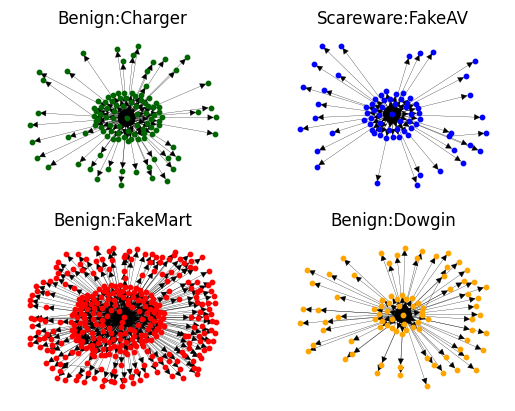

In [55]:
from functools import partial

my_layout = partial(nx.spring_layout, k=0.10, iterations=10)
fig, ax = plt.subplots(2,2)
families_plot = ["Charger", "FakeAV", "FakeMart", "Dowgin"]
colors = ["darkgreen", "blue", "red", "orange"]
for (idx_plot,fam) in enumerate(families_plot):
    idx = random.choice(t1.find_family(fam))
    print(fam, idx)
    t1.plot_graph(idx, layout=my_layout, ax=fig.axes[idx_plot], node_size=10, width=0.2, node_color=colors[idx_plot])

fig.savefig("../images/malware_graphs.png", dpi=300)

In [57]:
sample_data = t1.get(10)

In [203]:
sample_data.num_nodes

46

In [204]:
sample_data.edge_attr.shape

torch.Size([58, 77])

In [56]:
from torch_geometric.nn import GATConv, GATv2Conv
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F
import torch.nn as nn
import torch 


class GATModel(nn.Module):
    def __init__(self, node_embed_size=16, hidden_size=32, num_edge_features=10, max_nodes=10000):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.node_embedding = nn.Embedding(max_nodes, node_embed_size)
        # Initialize the embeddings with small random values
        nn.init.normal_(self.node_embedding.weight, std=0.1)
        self.convs = [
            GATv2Conv(node_embed_size, self.hidden_size, edge_dim=num_edge_features),
            GATv2Conv(self.hidden_size, self.hidden_size, edge_dim=num_edge_features),
        ]
        self.linear = nn.Linear(self.hidden_size, 2)
        self.edge_norm_layer = nn.BatchNorm1d(num_edge_features)

    def forward(self, data):
        edge_index, edge_attr = data.edge_index, data.edge_attr
        # want to get the node embeddings for the nodes in the batch
        
        edge_attr = self.edge_norm_layer(edge_attr)
        # edge_attr = edge_attr - edge_attr.mean(axis=0) # normalize the edge features
        # edge_attr = edge_attr / (edge_attr.std(axis=0) + 1e-4) # normalize the edge features
        x = self.node_embedding.weight[:data.num_nodes,:]
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr)  # adding edge features here!
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        x = self.convs[-1](
            x, edge_index, edge_attr=edge_attr
        )  # edge features here as well
        x = global_mean_pool(x, data.batch)  # [batch_size, hidden_channels]
        x = self.linear(x)
        return x

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc 

# import confusion_matrix
from sklearn.metrics import confusion_matrix

from dataclasses import dataclass

@dataclass
class EvaluationMetrics:
    epoch: int
    accuracy: float
    precision: float
    recall: float
    f1: float
    auc: float
    fpr: float
    tpr: float
    
    @classmethod
    def from_predictions(cls, y_true, y_pred, epoch: int = 0):
        
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=np.nan)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc_score = auc(fpr, tpr)
        return cls(epoch, accuracy, precision, recall, f1, auc_score, fpr, tpr)
    
    def __str__(self):
        return f"Accuracy: {self.accuracy:.4f}, Precision: {self.precision:.4f}, Recall: {self.recall:.4f}, F1: {self.f1:.4f}, AUC: {self.auc:.4f}" 
    
    
    def plot_roc(self, ax: plt.Axes = None, *args, **kwargs):
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(self.fpr, self.tpr, *args, **kwargs)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"ROC Curve (AUC={self.auc:.4f})")
        return ax
    
    def plot_confusion_matrix(self, y_true, y_pred, ax: plt.Axes = None, *args, **kwargs):
        if ax is None:
            fig, ax = plt.subplots()
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, ax=ax, *args, **kwargs)
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        ax.set_title(f"Confusion Matrix")
        return ax

In [58]:
model = GATModel(hidden_size=32, num_edge_features=77)
from torch_geometric.data import DataLoader

dl_test = DataLoader(t1, batch_size=32, shuffle=True)
for batch in dl_test:
    out = model(batch)
    print(out.shape)
    print(out)
    break

/home/khannay/miniconda3/envs/gnnflows/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


torch.Size([32, 2])
tensor([[-0.2219, -0.0815],
        [-0.2077, -0.1013],
        [-0.2030, -0.1141],
        [-0.2294, -0.1375],
        [-0.2689, -0.0378],
        [-0.2255, -0.1007],
        [-0.2097, -0.0818],
        [-0.2570, -0.1249],
        [-0.1411, -0.1046],
        [-0.2339, -0.1391],
        [-0.1758, -0.0706],
        [-0.2581, -0.1081],
        [-0.1593, -0.0722],
        [-0.1888, -0.0789],
        [-0.2476, -0.1310],
        [-0.1875, -0.1059],
        [-0.2059, -0.0834],
        [-0.2076, -0.1011],
        [-0.1794, -0.0892],
        [-0.2178, -0.1031],
        [-0.2386, -0.0925],
        [-0.2102, -0.1050],
        [-0.1487, -0.0761],
        [-0.2223, -0.1118],
        [-0.1539, -0.1029],
        [-0.2406, -0.1245],
        [-0.1446, -0.0580],
        [-0.2206, -0.1171],
        [-0.1736, -0.0778],
        [-0.1705, -0.0569],
        [-0.2019, -0.1236],
        [-0.2358, -0.1015]], grad_fn=<AddmmBackward0>)


In [61]:

bs = 32 # 32 
model = GATModel(hidden_size=32, num_edge_features=77, max_nodes=10000, node_embed_size=64)
train_loader = DataLoader(t1[:1500], batch_size=bs, shuffle=True)
test_loader = DataLoader(t1[1500:], batch_size=bs, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 5.0]))

valid_acc_list = [] 
train_acc_list = []
loss_train = [] 


def train():
    model.train()
    loss_all = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        # show the loss 
        loss_all += loss.item() * data.num_graphs    
        
    loss_train.append(loss_all / len(train_loader.dataset)) 
    print(f"Loss: {loss_all / len(train_loader.dataset):.4f}")     

def test(loader) -> 'EvaluationMetrics':
    model.eval()
    y_true = []
    y_pred = []     
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data)  
        y_true.append(data.y.numpy())
        y_pred.append(out.argmax(dim=1).numpy())      
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return EvaluationMetrics.from_predictions(y_true, y_pred)

for epoch in range(1, 50):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_list.append(train_acc)
    valid_acc_list.append(test_acc)
    print(epoch)
    print(train_acc)
    print(test_acc)
    # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc.accuracy:.8f}, Test Acc: {test_acc.accuracy:.8f}')

/home/khannay/miniconda3/envs/gnnflows/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Loss: 0.6940


/home/khannay/miniconda3/envs/gnnflows/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khannay/miniconda3/envs/gnnflows/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1
Accuracy: 0.8580, Precision: 0.0000, Recall: 0.0000, F1: nan, AUC: 0.5000
Accuracy: 0.6597, Precision: 0.0000, Recall: 0.0000, F1: nan, AUC: 0.5000
Loss: 0.6751
2
Accuracy: 0.8433, Precision: 0.1765, Recall: 0.0282, F1: 0.0486, AUC: 0.5032
Accuracy: 0.6534, Precision: 0.4333, Recall: 0.0610, F1: 0.1070, AUC: 0.5099
Loss: 0.6431
3
Accuracy: 0.8093, Precision: 0.2483, Recall: 0.1690, F1: 0.2011, AUC: 0.5422
Accuracy: 0.6470, Precision: 0.4608, Recall: 0.2207, F1: 0.2984, AUC: 0.5437
Loss: 0.6073
4
Accuracy: 0.7560, Precision: 0.2833, Recall: 0.4695, F1: 0.3534, AUC: 0.6365
Accuracy: 0.6486, Precision: 0.4815, Recall: 0.4272, F1: 0.4527, AUC: 0.5950
Loss: 0.5821
5
Accuracy: 0.7860, Precision: 0.3125, Recall: 0.4225, F1: 0.3593, AUC: 0.6343
Accuracy: 0.6773, Precision: 0.5329, Recall: 0.4178, F1: 0.4684, AUC: 0.6145
Loss: 0.5631
6
Accuracy: 0.8213, Precision: 0.3962, Recall: 0.4930, F1: 0.4393, AUC: 0.6843
Accuracy: 0.6949, Precision: 0.5647, Recall: 0.4507, F1: 0.5013, AUC: 0.6358
Loss:

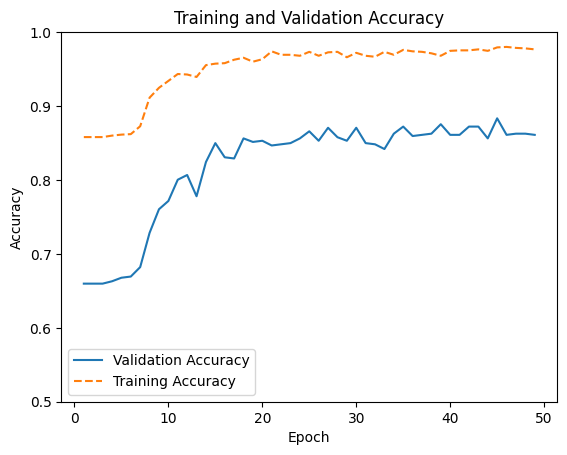

In [45]:
plt.plot(range(1, len(valid_acc_list)+1), [t.accuracy for t in valid_acc_list], label='Validation Accuracy')
plt.plot(range(1, len(train_acc_list)+1), [t.accuracy for t in train_acc_list], label='Training Accuracy', ls="--")
plt.ylabel("Accuracy")
plt.legend()
# add auc score on second y axis
# plt.twinx()
# plt.plot(range(1, len(valid_acc_list)+1), [t.auc for t in valid_acc_list], label='Validation AUC', color='red')
# plt.plot(range(1, len(train_acc_list)+1), [t.auc for t in train_acc_list], label='Training AUC', color='red', ls="--")
# plt.ylabel("AUC")
# plt.legend()

plt.ylim(0.5, 1)
plt.xlabel("Epoch")
plt.title("Training and Validation Accuracy")
plt.savefig("../images/gat_accuracy.png", dpi=300)



<Axes: title={'center': 'ROC Curve (AUC=0.8060)'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

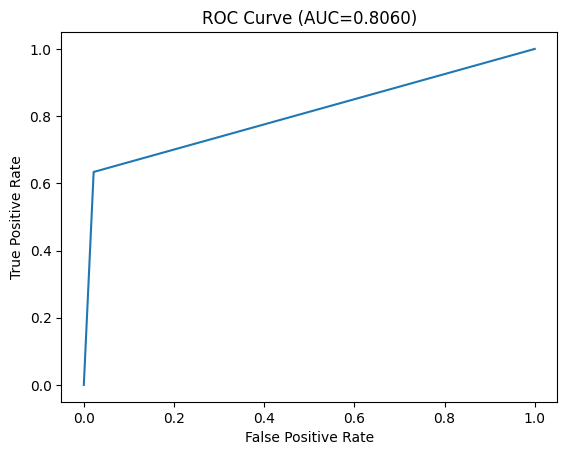

In [43]:
valid_acc_list[-1].plot_roc()

In [44]:
valid_acc_list[-1].f1


0.7563025210084034

In [3]:
#| hide
import nbdev; nbdev.nbdev_export()